In [1]:
import os, io
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from mentorship.features.garment.etl import ETLTransformer
from mentorship.ml.cv.util import format_cv_test_scores
from mentorship.ml.cv.garment.split import splitter
from mentorship.ml.models.garment.logreg import LogRegPipeline
from mentorship.ml.models.common import RecursiveTSEstimator
from mentorship.ml.tools.garment.curves import plot_learning_curver
from mentorship.ml.tools.garment.evaluation import plot_confusion_matrix, plot_lift_curve

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
CV_METRICS = [
    'accuracy',
    'precision',
    'recall',
    'f1'
]

In [4]:
def final_preds_metrics(y_true, y_pred, save_scores=False, print_scores=True):
    scores = {'accuracy': round(accuracy_score(y_true, y_pred), 3),
              'precision': round(precision_score(y_true, y_pred), 3),
              'recall': round(recall_score(y_true, y_pred), 3),
              'f1': round(f1_score(y_true, y_pred), 3)}
    if print_scores:
        print('accuracy:', scores['accuracy'])
        print('precision:', scores['precision'])
        print('recall:', scores['recall'])
        print('f1:', scores['f1'])
    
    if save_scores:
        return scores

In [5]:
def train_val_scores(cv_scores, title='Logistic Regression'):
    metric_values = {}
    plt.figure(figsize=(6, 3))
    for metric_name in cv_scores[0]:
        metric_values[metric_name] = [cv_scores[0][metric_name], cv_scores[1][metric_name], cv_scores[2][metric_name]]
    sns.heatmap(data=pd.DataFrame(data=metric_values, index=['Train score', 'Val score', 'Val std']).T, annot=True, annot_kws={'fontsize': 15})
    plt.yticks(fontsize=15, rotation=0)
    plt.xticks(fontsize=15)
    plt.title(title, fontsize=15)

In [6]:
def format_cv_train_test_scores(scores):
    train_scores, test_scores = {}, {}
    for metric_name, metric_values in scores.items():
        if metric_name.startswith('test_'):
            metric_name = metric_name[len('test_'):]
            if metric_name.startswith('neg_'):
                metric_name = metric_name[len('neg_'):]
                metric_values = -metric_values.copy()

            if metric_name == 'mean_squared_log_error':
                metric_name = 'root_mean_squared_log_error'
                metric_values = np.sqrt(metric_values)

            test_scores[metric_name] = metric_values
            
        if metric_name.startswith('train_'):
            metric_name = metric_name[len('train_'):]
            if metric_name.startswith('neg_'):
                metric_name = metric_name[len('neg_'):]
                metric_values = -metric_values.copy()

            if metric_name == 'mean_squared_log_error':
                metric_name = 'root_mean_squared_log_error'
                metric_values = np.sqrt(metric_values)

            train_scores[metric_name] = metric_values

    return train_scores, test_scores

In [7]:
def train_val_scores_each_fold(cv_train_test_scores, model='Logistic Regression'):
    metric_values = {}
    for fold in range(4):
        plt.figure(figsize=(6, 3))
        metric_values[f'{fold + 1} fold'] = {}
        for metric_name in cv_train_test_scores[0]:
            metric_values[f'{fold + 1} fold'][metric_name] = [cv_train_test_scores[0][metric_name][fold], cv_train_test_scores[1][metric_name][fold]]
        sns.heatmap(data=pd.DataFrame(data=metric_values[f'{fold + 1} fold'], index=['Train score', 'Val score']).T, 
                    annot=True, annot_kws={'fontsize': 15})
        plt.yticks(fontsize=15, rotation=0)
        plt.xticks(fontsize=15)
        plt.title(f'{fold + 1} fold', fontsize=15)
        plt.show()

In [8]:
def plot_cumulative_gain_curve(y_true, y_proba, rare_class_prop, step=0.1, title='Cumulative Gains Curve', ax=None, 
                               figsize=None, title_fontsize='large', text_fontsize='medium'):    
    x_v = np.round(np.arange(0, 1 + step, step), 1)
    zeros_number = len(y_true[y_true == 0])
    
    for i, current_proba in enumerate(y_proba):
        aux_lift = pd.DataFrame()
        aux_lift['real'] = y_true
        aux_lift['predicted'] = current_proba
        aux_lift.sort_values('predicted', ascending=False, inplace=True)
        y_v = []
        
        for x in x_v:
            num_data = int(np.ceil(x * len(aux_lift)))
            data_here = aux_lift.iloc[:num_data, :]
            zeros_number_here = (data_here['real'] == 0).sum()
            y_v.append(zeros_number_here / zeros_number)
        
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        ax.plot(x_v, y_v, lw=2, label=f'Model {i + 1}')
        
    ax.plot([0, rare_class_prop, 1], [0, 1, 1], 'y--', lw=2, label='Perfect model')
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xticks(x_v, x_v)
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Baseline')
    ax.set_xlabel('Percentage of sample', fontsize=text_fontsize)
    ax.set_ylabel('Positive responses, %', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.grid('on')
    ax.legend(loc='lower right', fontsize=text_fontsize)

In [9]:
os.chdir(os.environ['PROJECT_ROOT'])
DATA_ROOT = Path('data', 'productivity-prediction-garment-employees')

In [10]:
# preparing the dataset (ETL stage)

train_data = pd.read_csv(DATA_ROOT / 'garments_worker_productivity.csv')

X = ETLTransformer().transform(train_data)
y = X['bigger_than_targeted'].copy()

X.sample(5)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,bigger_than_targeted
577,2015-02-04,Quarter1,sweing,Wednesday,10,0.80,22.52,1108.0,6720.0,113,0.0,0,0,56.0,1
937,2015-02-26,Quarter4,sweing,Thursday,1,0.35,26.66,1164.0,5040.0,23,0.0,0,2,55.0,1
870,2015-02-23,Quarter4,sweing,Monday,2,0.70,30.33,577.0,6840.0,30,0.0,0,1,58.0,1
681,2015-02-10,Quarter2,finishing,Tuesday,8,0.35,4.15,1.0,1800.0,0,0.0,0,0,8.0,1
64,2015-01-06,Quarter1,finishing,Tuesday,11,0.80,4.15,1.0,2400.0,0,0.0,0,0,15.0,1


In [11]:
# dividing the whole dataset on train and test parts

X_train, y_train = X[X['date'] < '2015-03-05'], y.loc[X[X['date'] < '2015-03-05'].index]
X_test, y_test = X[X['date'] >= '2015-03-05'], y.loc[X[X['date'] >= '2015-03-05'].index]

In [12]:
# inner folds for params tuning

inner_folds = []
inner_folds.append((X_train[X_train['date'] <= '2015-01-20']['date'].unique(), X_train[(X_train['date'] > '2015-01-20') & (X_train['date'] <= '2015-01-27')]['date'].unique()))
inner_folds.append((X_train[X_train['date'] <= '2015-01-27']['date'].unique(), X_train[(X_train['date'] > '2015-01-27') & (X_train['date'] <= '2015-02-03')]['date'].unique()))

In [13]:
n_folds = 4
test_size = 6

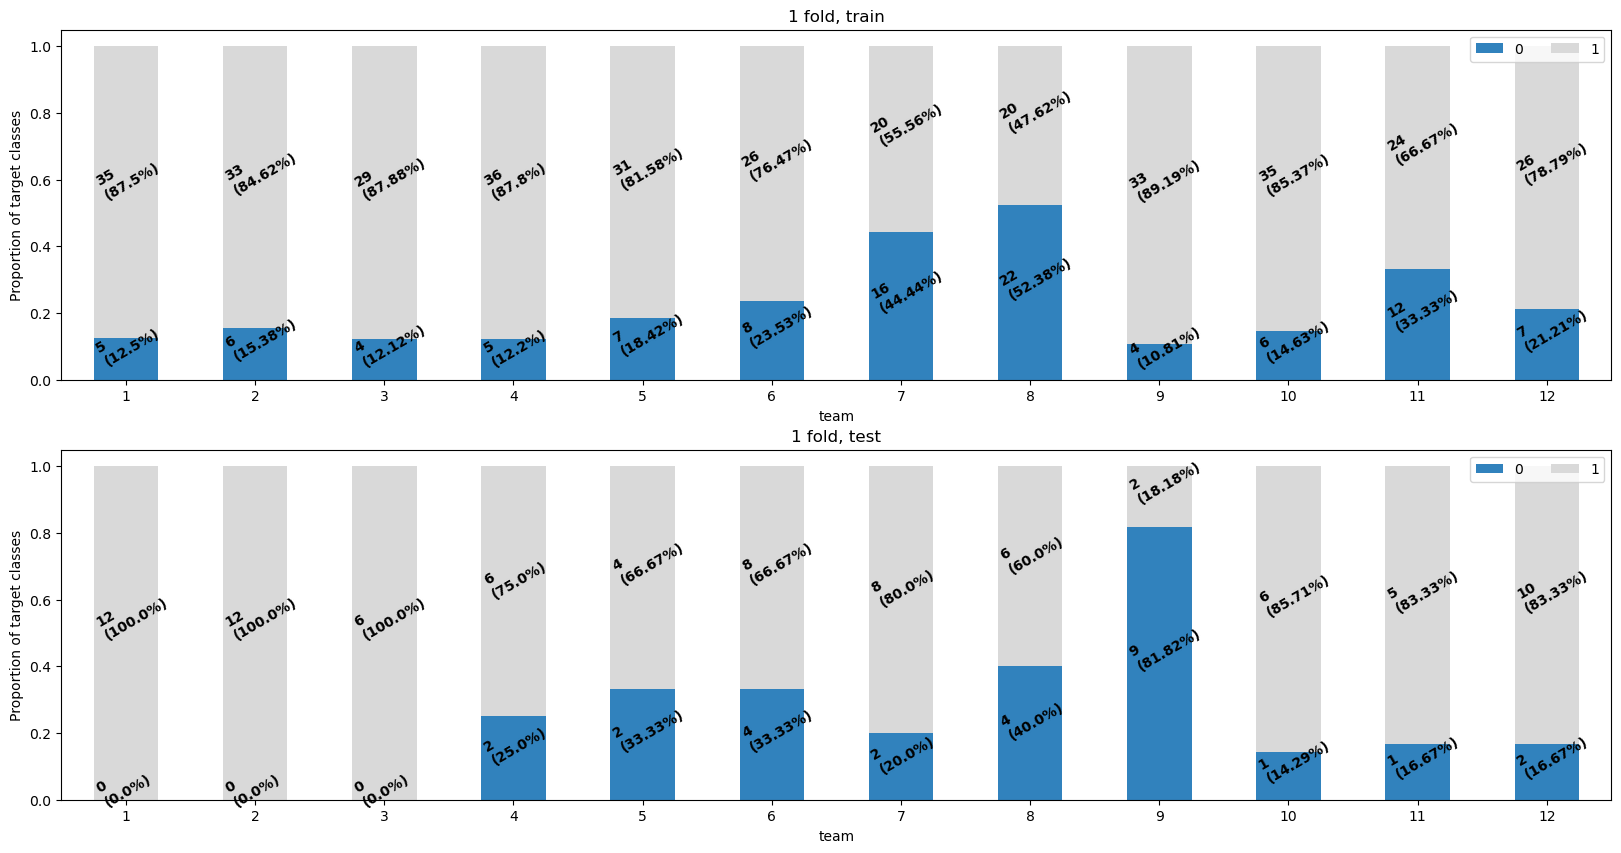

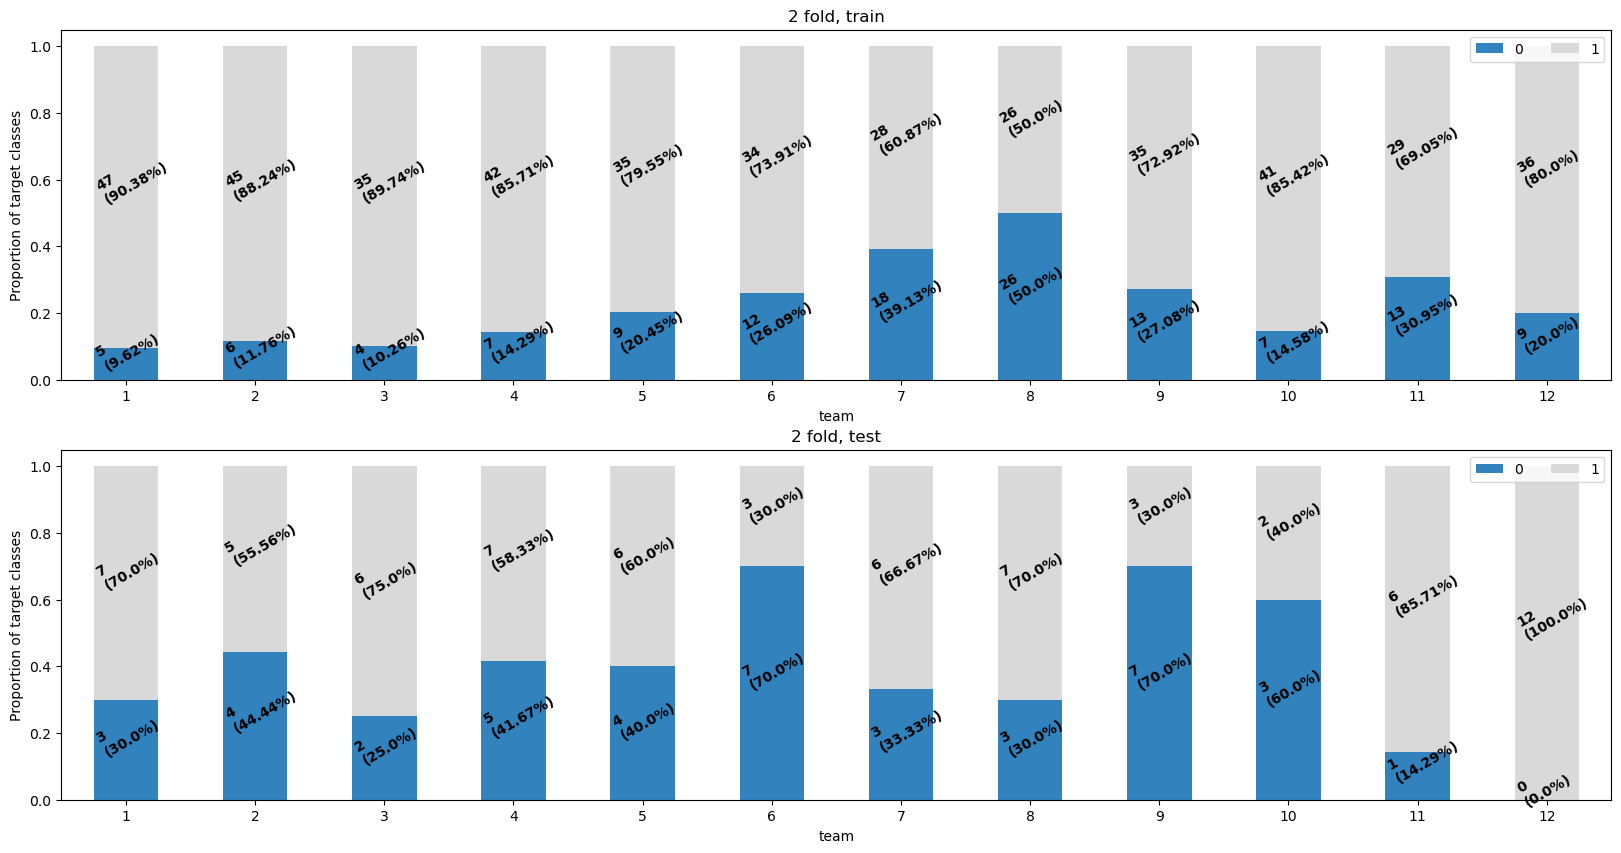

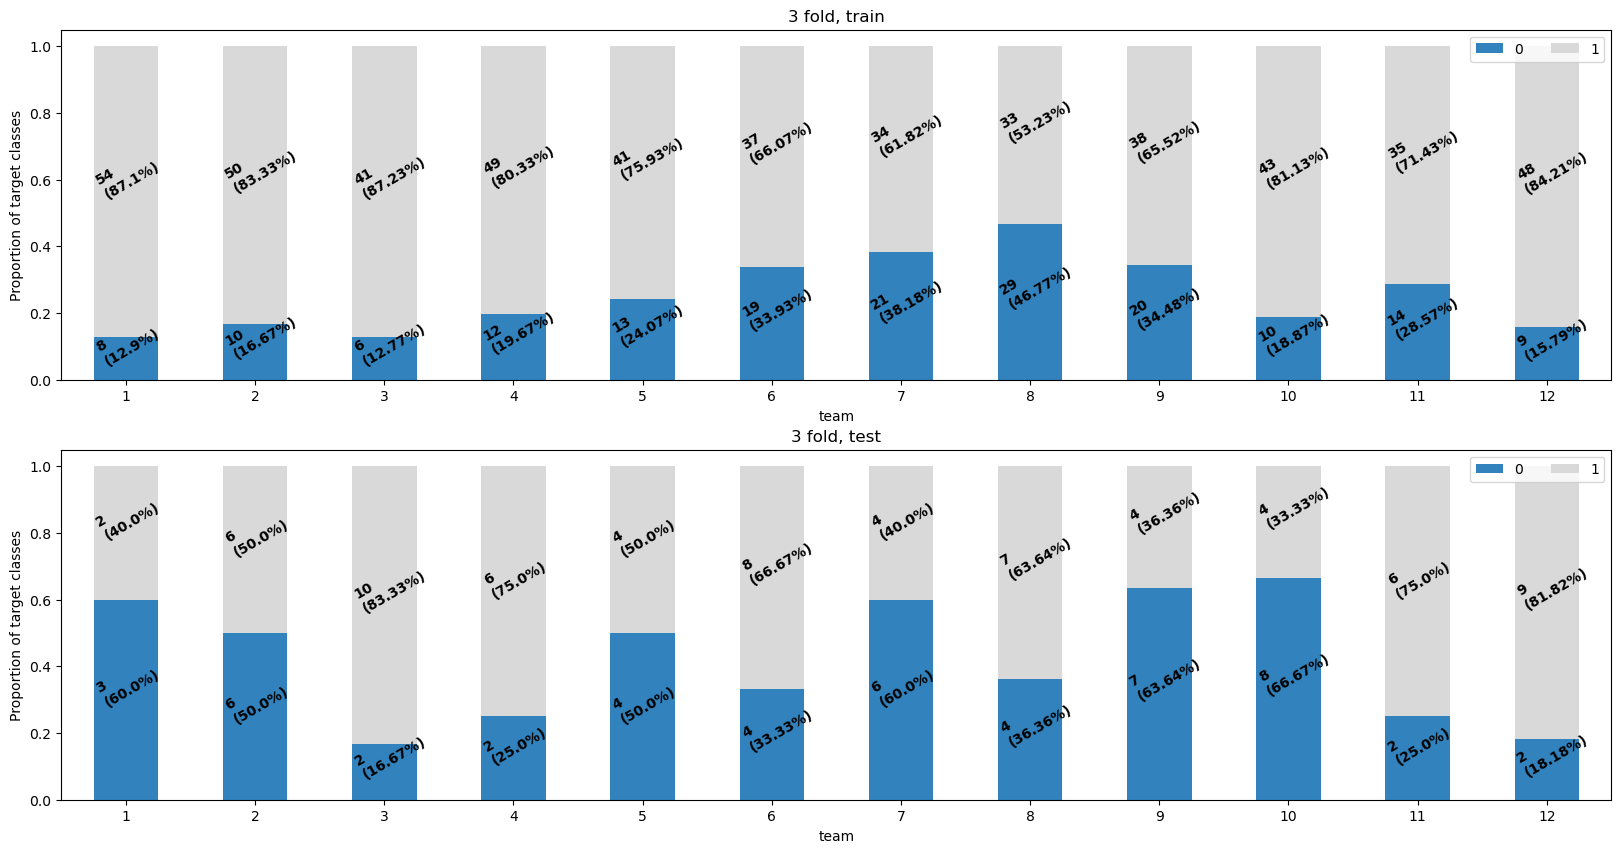

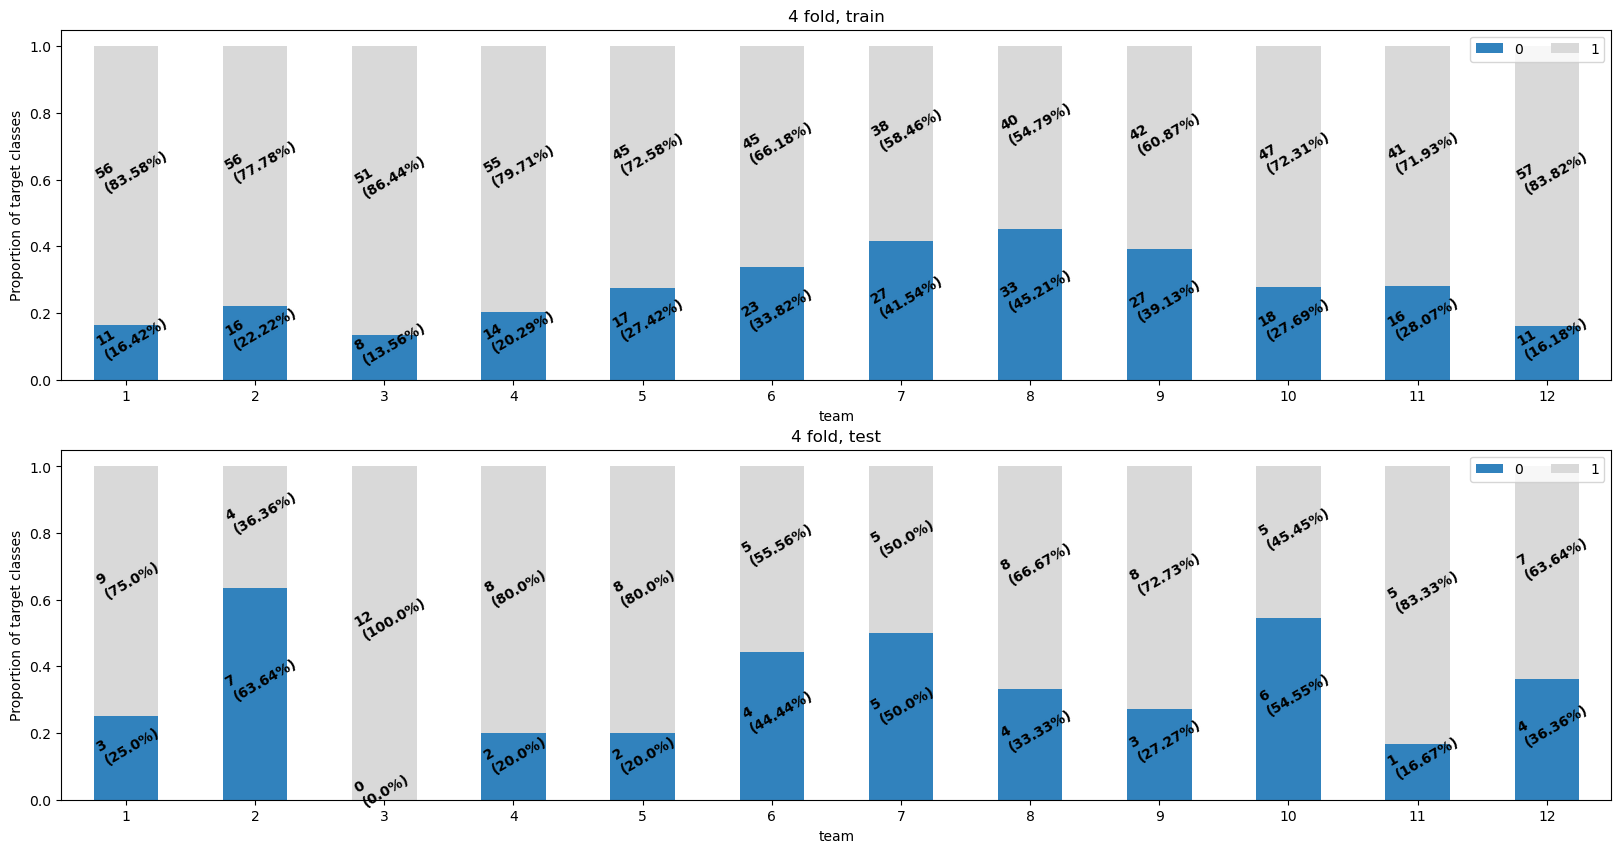

In [14]:
for i, (train_ind, test_ind) in enumerate(splitter(X_train)):
    plt.figure(figsize=(20, 10))
    X_train_fold, X_val_fold = X_train.loc[train_ind, :], X_train.loc[test_ind, :]
    
    for j, (X_part, part) in enumerate(zip([X_train_fold, X_val_fold], ['train', 'test'])):
        ax = plt.subplot(2, 1, j + 1)
        cross_tab = pd.crosstab(index=X_part['team'], columns=X_part['bigger_than_targeted'])
        cross_tab_prop = pd.crosstab(index=X_part['team'], columns=X_part['bigger_than_targeted'], normalize='index')#.sort_values(by=0)
        cross_tab_prop.plot(ax=ax, kind='bar', stacked=True, colormap='tab20c')
        plt.ylabel('Proportion of target classes')
        plt.xlabel('team')
        plt.legend(loc='upper right', ncol=2)
        for n, x in enumerate([*cross_tab_prop.index.values]):
            for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x], cross_tab.loc[x], cross_tab_prop.loc[x].cumsum()):
                plt.text(x=n - 0.25, y=(y_loc - proportion - 0.02) + (proportion / 2), s=f'{count}\n({np.round(proportion * 100, 2)}%)', 
                         color='black', fontsize=10, fontweight='bold', rotation=30)
                plt.xticks(rotation=0)
        plt.title(f'{i + 1} fold, {part}')
        
    plt.show()

# ML Flow

In [15]:
import mlflow

def create_experiment(model, experiment_name, model_params=None, metric_scores=None, confusion_matrix_path=None, 
                      roc_auc_plot_path=None):
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run():
        if model_params is not None:
            for param in model_params:
                mlflow.log_param(param, model_params[param])
        
        if metric_scores is not None:
            mlflow.log_metric('accuracy', round(metric_scores['accuracy'], 3))
            mlflow.log_metric('precision', round(metric_scores['precision'], 3))
            mlflow.log_metric('recall', round(metric_scores['recall'], 3))
            mlflow.log_metric('f1', round(metric_scores['f1'], 3))
        
        if confusion_matrix_path is not None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
        
        if roc_auc_plot_path is not None:
            mlflow.log_artifact(roc_auc_plot_path, 'roc_auc_plot')
        
        mlflow.sklearn.log_model(model, 'model')
    
    print(f'Run is logged to Experiment {experiment_name}')

# Logistic Regression (best model)

accuracy: 0.702 ± 0.049
precision: 0.713 ± 0.066
recall: 0.916 ± 0.016
f1: 0.800 ± 0.041


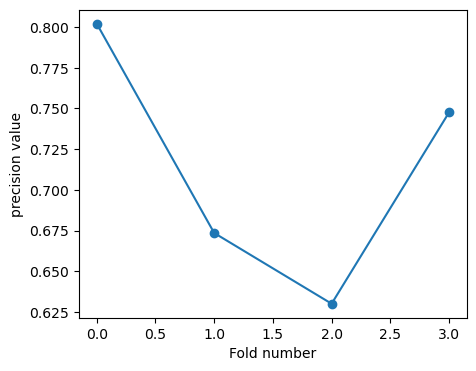

In [16]:
# cross validation (only MinMax scaling)

drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive']}
cols_to_scale = {'sweing': ['smv', 'wip', 'incentive', 'no_of_workers', 'over_time'], 
                 'finishing': ['smv', 'no_of_workers', 'over_time']}
cols_to_standard_scale = {'sweing': ['idle_men'], 
                          'finishing': ['idle_men']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'],
                                          target_col='bigger_than_targeted', level='team', cols_to_standard_scale=cols_to_standard_scale['sweing'])
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], cols_to_standard_scale=cols_to_standard_scale['finishing'],
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, target_col='bigger_than_targeted', 
                                                 learning_curve=True, split_key='department')

scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

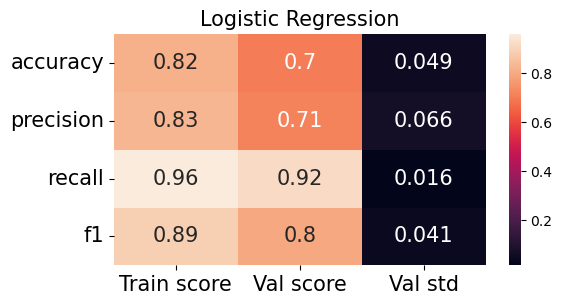

In [17]:
train_val_scores(cv_scores)

In [18]:
drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive']}
cols_to_scale = {'sweing': ['smv', 'incentive', 'over_time'], 
                 'finishing': ['smv', 'no_of_workers', 'over_time']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}
cols_to_standard_scale = {'sweing': ['wip', 'no_of_workers'],
                          'finishing': ['no_of_workers']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'],
                                          target_col='bigger_than_targeted', level='team', cols_to_standard_scale=cols_to_standard_scale['sweing'])
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], cols_to_standard_scale=cols_to_standard_scale['finishing'],
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team')

accuracy: 0.704 ± 0.052
precision: 0.716 ± 0.069
recall: 0.916 ± 0.008
f1: 0.802 ± 0.042


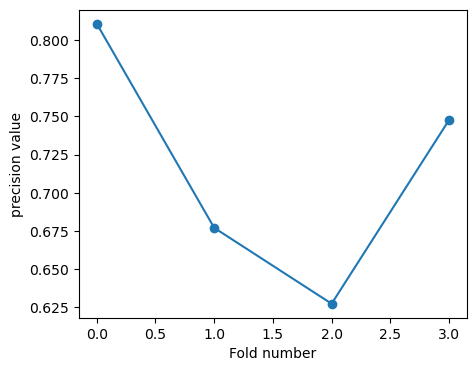

In [19]:
# cross validation (MinMax + StandardScaler)

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)

scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

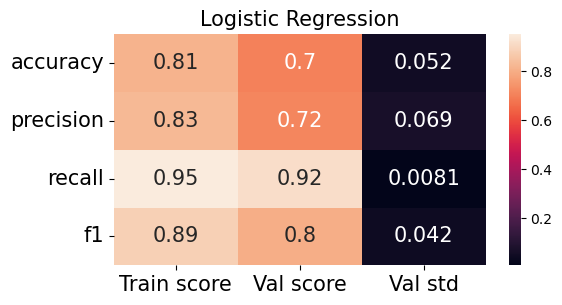

In [20]:
train_val_scores(cv_scores)

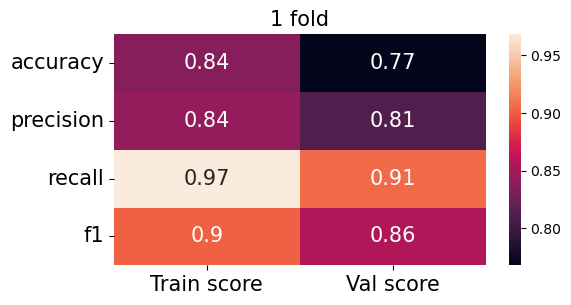

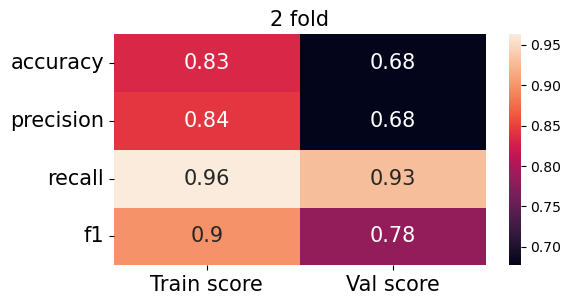

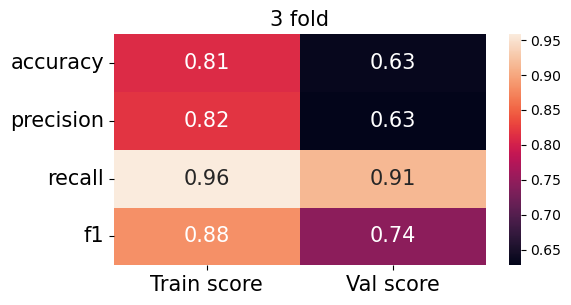

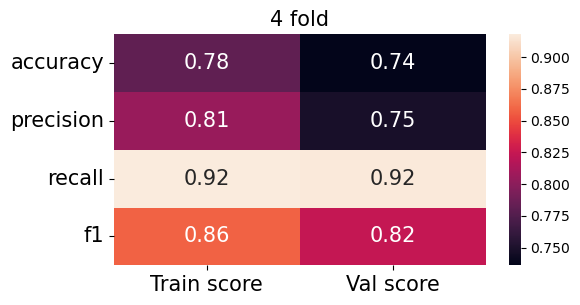

In [21]:
cv_train_test_scores = format_cv_train_test_scores(scores)
train_val_scores_each_fold(cv_train_test_scores)

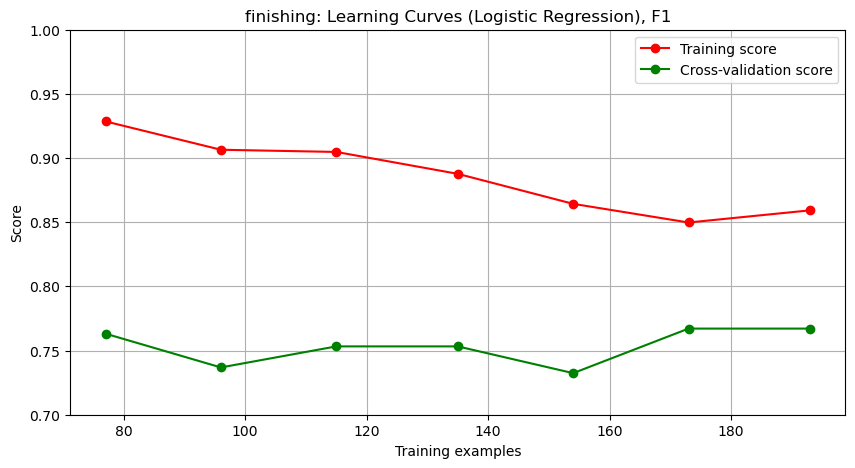

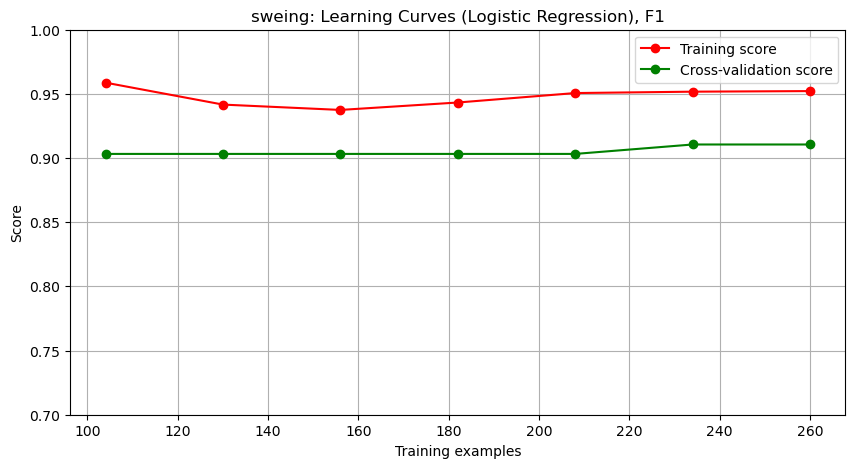

In [22]:
lc_fold_train, lc_fold_test = [j for i in [inner_folds[0][0], inner_folds[0][1], inner_folds[1][0]] for j in i] , inner_folds[1][1]
lc_fold = [(np.array(list((dict.fromkeys(lc_fold_train)))), lc_fold_test)]
plot_learning_curver(X_train, y_train, tscv_inner=lc_fold, base_pipelines=base_pipelines)

In [23]:
# getting X_train and y_train for the final model training

date_range_final = X_train['date'].unique()[test_size:]
X_train_final, y_train_final = X_train[X_train['date'].isin(date_range_final)], y_train.loc[X_train[X_train['date'].isin(date_range_final)].index]

accuracy: 0.837
precision: 0.893
recall: 0.902
f1: 0.898


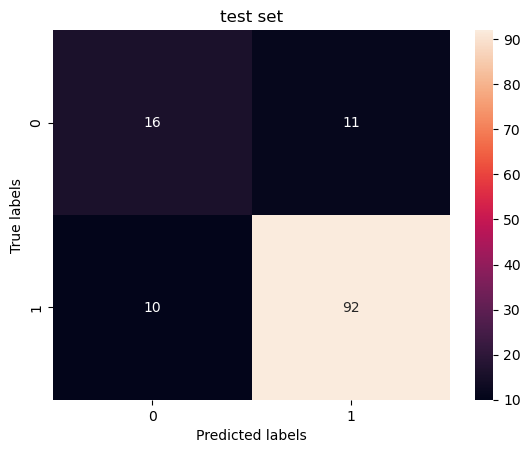

In [24]:
modelling_pipeline_logreg.fit(X_train_final, y_train_final)
final_preds = modelling_pipeline_logreg.predict(X_test)
temp_file = plot_confusion_matrix(y_true=y_test, y_pred=final_preds, save_plot=False)
final_preds_metrics(y_test, final_preds)

train set scores: 

accuracy: 0.791
precision: 0.815
recall: 0.915
f1: 0.862


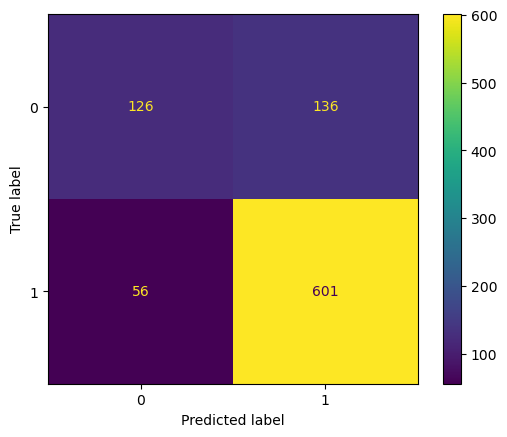

In [25]:
train_preds = modelling_pipeline_logreg.predict(X_train_final)
print('train set scores: \n')
ConfusionMatrixDisplay.from_predictions(y_train_final, train_preds)

final_preds_metrics(y_train_final, train_preds)

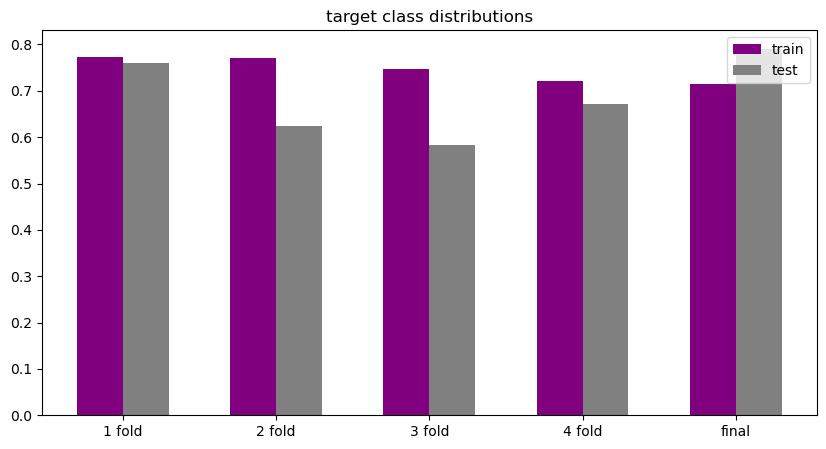

In [26]:
train_sets = []
val_and_test_sets = []
for fold_number, (train_ind, test_ind) in enumerate(splitter(X_train)):
    train_sets.append(round(y_train.loc[train_ind].mean(), 3))
    val_and_test_sets.append(round(y_train.loc[test_ind].mean(), 3))
train_sets.append(round(y_train_final.mean(), 3))
val_and_test_sets.append(round(y_test.mean(), 3))

ind = np.arange(1, 6)
width = 0.3

plt.figure(figsize=(10, 5))
plt.bar(ind, train_sets, width, color='purple')
plt.bar(ind + width, val_and_test_sets, width, color='gray')
plt.xticks(ind + width / 2, ['1 fold', '2 fold', '3 fold', '4 fold', 'final'])
plt.legend(['train', 'test'])
plt.title('target class distributions')
plt.show()

### Logging experiments

accuracy: 0.793 ± 0.075
precision: 0.861 ± 0.056
recall: 0.852 ± 0.067
f1: 0.856 ± 0.061


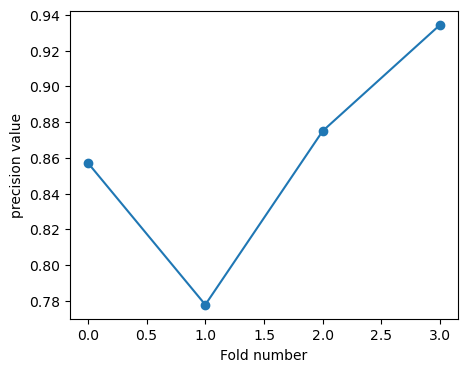

In [27]:
# 'sweing' department

class_weight = {'sweing': {0: 1.8, 1: 1}}
X_train_sweing = X_train[X_train['department'] == 'sweing'].reset_index(drop=True)
y_train_sweing = y_train.loc[X_train[X_train['department'] == 'sweing'].index].reset_index(drop=True)

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department', class_weight=class_weight,
                                                 target_col='bigger_than_targeted', learning_curve=True)
scores_sweing = cross_validate(modelling_pipeline_logreg, X_train_sweing, y_train_sweing, cv=splitter(X_train_sweing), n_jobs=-1,
                               scoring=CV_METRICS, return_estimator=True, error_score='raise', return_train_score=True)
cv_scores_sweing = format_cv_test_scores(scores_sweing, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

accuracy: 0.897
precision: 0.952
recall: 0.938
f1: 0.945


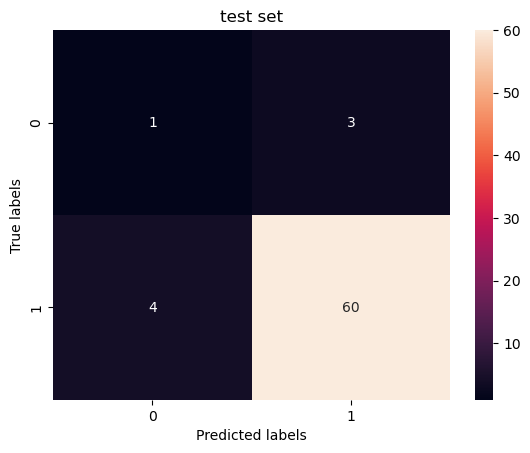

In [28]:
# fitting the final model and making predictions

X_train_final_sweing = X_train_final[X_train_final['department'] == 'sweing']
y_train_final_sweing = y_train_final.loc[X_train_final_sweing.index]
X_test_sweing = X_test[X_test['department'] == 'sweing']
y_test_sweing = y_test.loc[X_test_sweing.index]

modelling_pipeline_logreg.fit(X_train_final_sweing, y_train_final_sweing)
final_preds_sweing = modelling_pipeline_logreg.predict(X_test_sweing)

temp_file = plot_confusion_matrix(y_true=y_test_sweing, y_pred=final_preds_sweing, save_plot=True)

final_preds_metrics(y_test_sweing, final_preds_sweing)

In [29]:
create_experiment(model=modelling_pipeline_logreg, experiment_name='LogReg_sweing', model_params=class_weight, 
                  metric_scores=cv_scores_sweing[1], confusion_matrix_path=temp_file.name)

temp_file.close()
os.unlink(temp_file.name)

Run is logged to Experiment LogReg_sweing


accuracy: 0.593 ± 0.095
precision: 0.570 ± 0.128
recall: 0.885 ± 0.048
f1: 0.687 ± 0.101


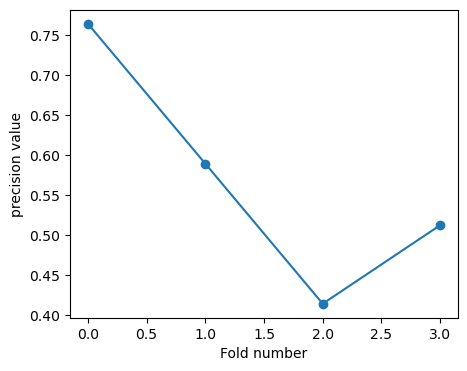

In [30]:
# 'finishing' department

class_weight = {'finishing': {0: 1, 1: 1}}
X_train_finishing = X_train[X_train['department'] == 'finishing'].reset_index(drop=True)
y_train_finishing = y_train.loc[X_train[X_train['department'] == 'finishing'].index].reset_index(drop=True)

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department', class_weight=class_weight,
                                                 target_col='bigger_than_targeted', learning_curve=True)
scores_finishing = cross_validate(modelling_pipeline_logreg, X_train_finishing, y_train_finishing, cv=splitter(X_train_finishing),
                                  scoring=CV_METRICS, return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores_finishing = format_cv_test_scores(scores_finishing, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

accuracy: 0.77
precision: 0.8
recall: 0.842
f1: 0.821


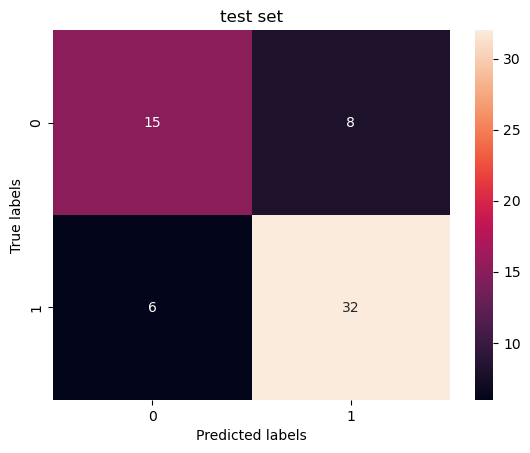

In [31]:
# fitting the final model and making predictions

X_train_final_finishing = X_train_final[X_train_final['department'] == 'finishing']
y_train_final_finishing = y_train_final.loc[X_train_final_finishing.index]
X_test_finishing = X_test[X_test['department'] == 'finishing']
y_test_finishing = y_test.loc[X_test_finishing.index]

modelling_pipeline_logreg.fit(X_train_final_finishing, y_train_final_finishing)
final_preds_finishing = modelling_pipeline_logreg.predict(X_test_finishing)

temp_file = plot_confusion_matrix(y_true=y_test_finishing, y_pred=final_preds_finishing, save_plot=True)

final_preds_metrics(y_test_finishing, final_preds_finishing)

In [32]:
create_experiment(model=modelling_pipeline_logreg, experiment_name='LogReg_finishing', model_params=class_weight, 
                  metric_scores=cv_scores_finishing[1], confusion_matrix_path=temp_file.name)

temp_file.close()
os.unlink(temp_file.name)

Run is logged to Experiment LogReg_finishing


# Analysis of every continuous feature on leaks. ('smv', 'wip', 'incentive', 'no_of_workers')

## 'smv'

accuracy: 0.732 ± 0.031
precision: 0.761 ± 0.061
recall: 0.870 ± 0.030
f1: 0.810 ± 0.029


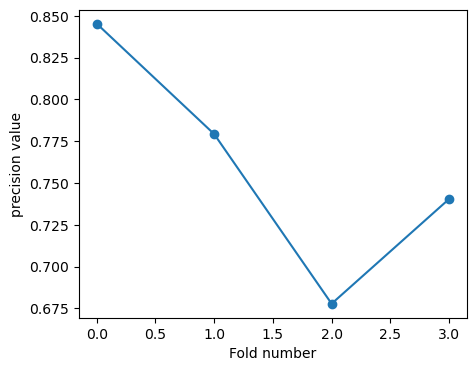

In [33]:
# cross validation

drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'over_time', 'smv'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'over_time', 'smv']}
cols_to_scale = {'sweing': ['wip', 'incentive', 'no_of_workers'], 
                 'finishing': ['no_of_workers']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'],
                                          target_col='bigger_than_targeted', level='team')
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], 
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)

scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

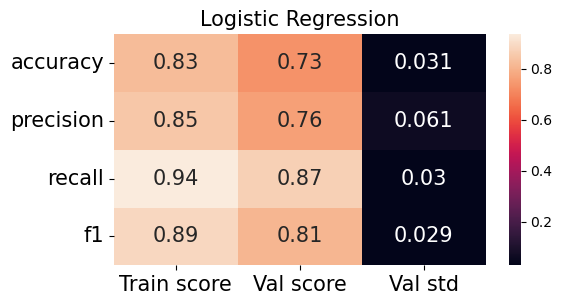

In [34]:
train_val_scores(cv_scores)

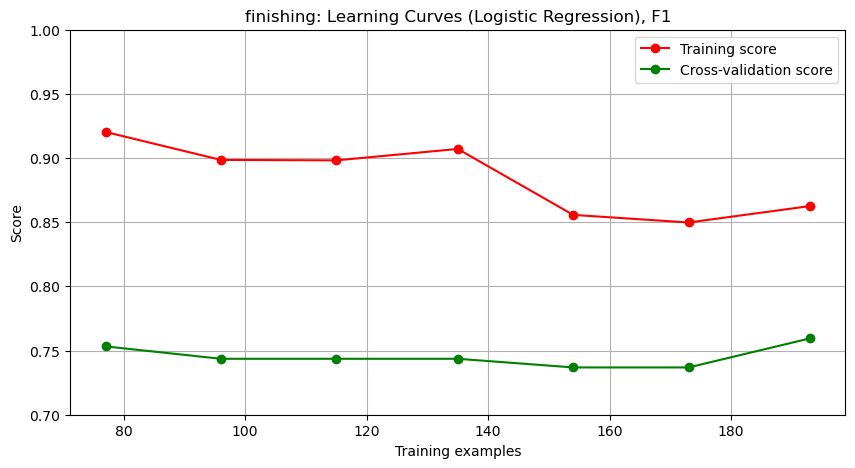

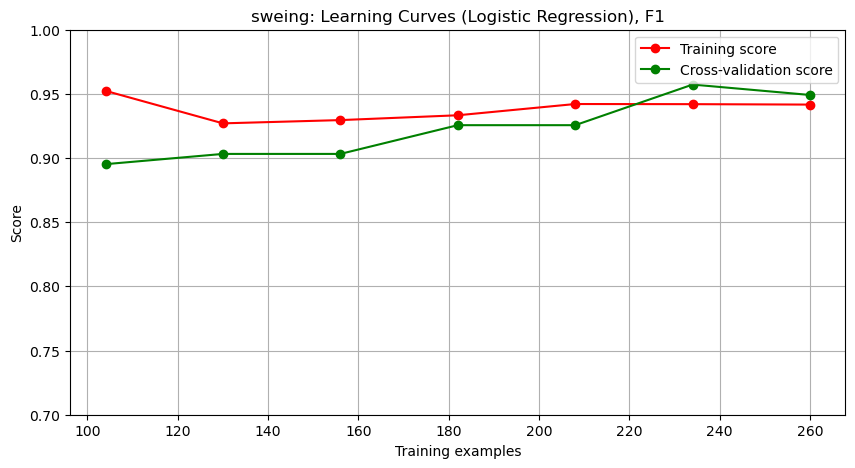

In [35]:
plot_learning_curver(X_train, y_train, tscv_inner=lc_fold, base_pipelines=base_pipelines)

In [36]:
cv_scores_lags_smv = {}
for lag in [1, 2, 3, 4, 5, 6]:
    X_copy = ETLTransformer(lags=[lag], lagged_feature='smv').transform(train_data)
    X_copy = X_copy.dropna(subset=[f'smv_lag_{lag}']).reset_index(drop=True)
    y_copy = X_copy['bigger_than_targeted'].copy()
    X_train_copy, y_train_copy = X_copy[X_copy['date'] < '2015-03-05'], y_copy.loc[X_copy[X_copy['date'] < '2015-03-05'].index]
    X_test_copy, y_test_copy = X_copy[X_copy['date'] >= '2015-03-05'], y_copy.loc[X_copy[X_copy['date'] >= '2015-03-05'].index]

    drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'over_time'],
                    'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'over_time']}
    cols_to_scale = {'sweing': ['wip', 'incentive', 'no_of_workers', f'smv_lag_{lag}'],
                     'finishing': ['no_of_workers', f'smv_lag_{lag}']}
    cols_to_encode = {'sweing': ['team'],
                      'finishing': ['team']}

    base_pipelines = {}
    base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                              split_key='department', drop_columns=drop_columns['sweing'],
                                              target_col='bigger_than_targeted', level='team')
    base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'],
                                                 cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                                 split_key='department', target_col='bigger_than_targeted', level='team')

    modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                     target_col='bigger_than_targeted', learning_curve=True)

    scores = cross_validate(modelling_pipeline_logreg, X_train_copy, y_train_copy, cv=splitter(X_train_copy), scoring=CV_METRICS, 
                            return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
    cv_scores_lags_smv[lag] = format_cv_test_scores(scores, save_scores=True, save_train_scores=True, print_scores=False)

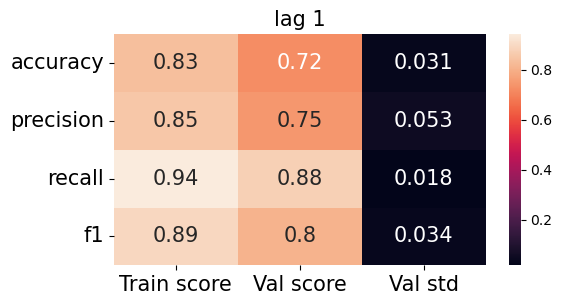

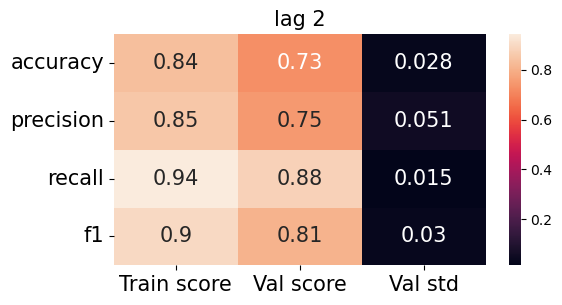

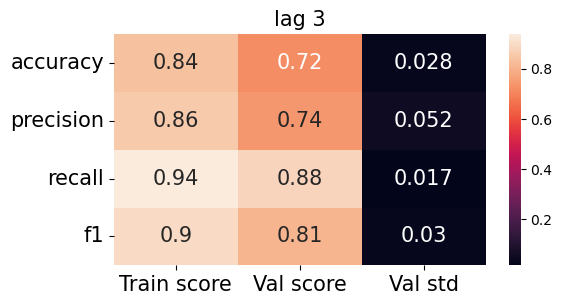

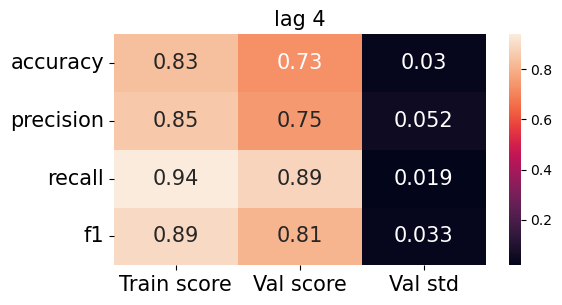

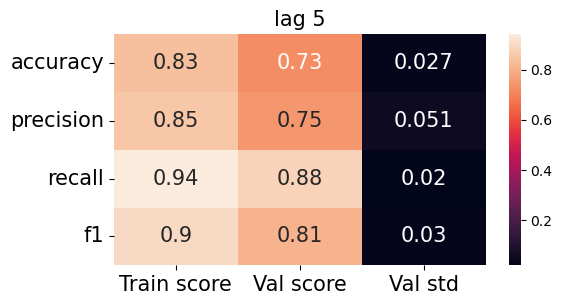

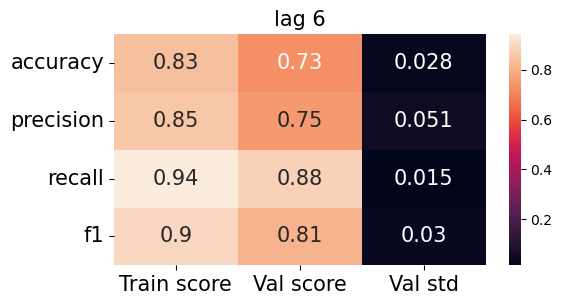

In [37]:
for i, lag in enumerate(cv_scores_lags_smv.keys()):
    train_val_scores(cv_scores_lags_smv[lag], title=f'lag {lag}')

<p><b>As we can see, none of lags give any 'overfitting' improvements, so it means that we can use 'smv' original feature in our modelling strategy. (actually, model with and without 'smv' feature has almost the same 'overfitting' measure level, so 'smv' doesn't have any leaks)</b></p>

## 'wip'

accuracy: 0.725 ± 0.027
precision: 0.747 ± 0.052
recall: 0.880 ± 0.015
f1: 0.807 ± 0.031


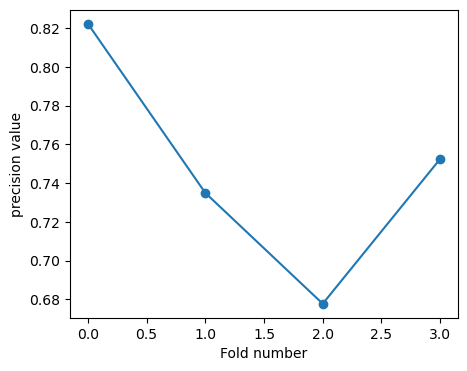

In [38]:
# cross validation

drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'over_time', 'wip'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'over_time']}
cols_to_scale = {'sweing': ['smv', 'incentive', 'no_of_workers'], 
                 'finishing': ['smv', 'no_of_workers']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'],
                                          target_col='bigger_than_targeted', level='team')
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], 
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)

scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

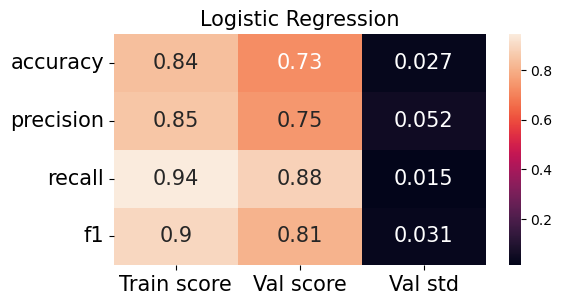

In [39]:
train_val_scores(cv_scores)

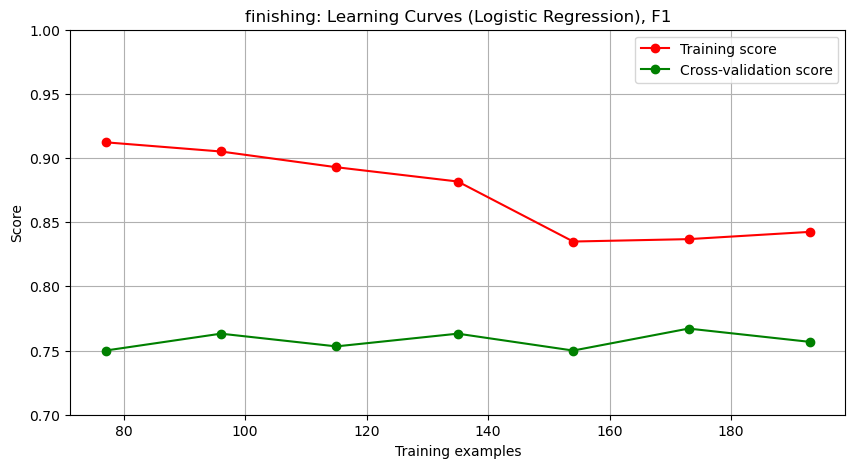

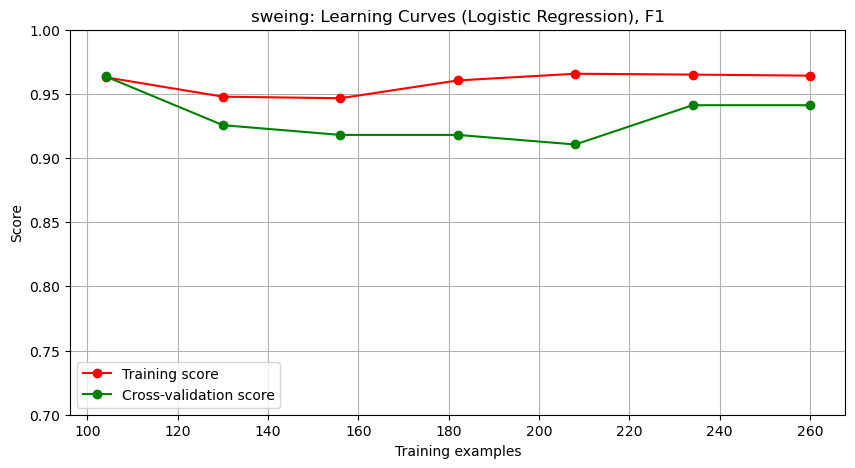

In [40]:
plot_learning_curver(X_train, y_train, tscv_inner=lc_fold, base_pipelines=base_pipelines)

## 'incentive'

accuracy: 0.672 ± 0.052
precision: 0.685 ± 0.066
recall: 0.933 ± 0.011
f1: 0.788 ± 0.040


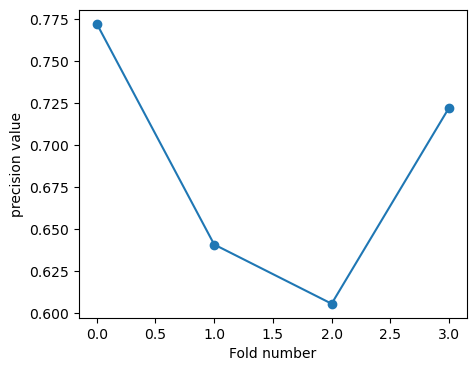

In [41]:
# cross validation

drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'over_time', 'incentive'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'over_time']}
cols_to_scale = {'sweing': ['smv', 'wip', 'no_of_workers'], 
                 'finishing': ['smv', 'no_of_workers']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'],
                                          target_col='bigger_than_targeted', level='team')
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], 
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)

scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

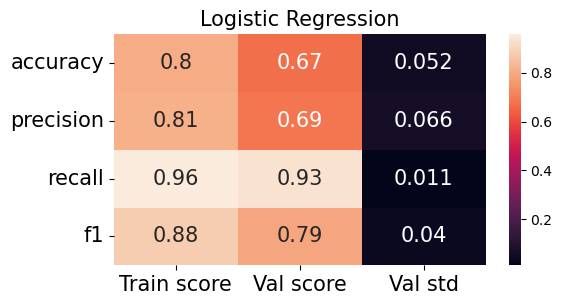

In [42]:
train_val_scores(cv_scores)

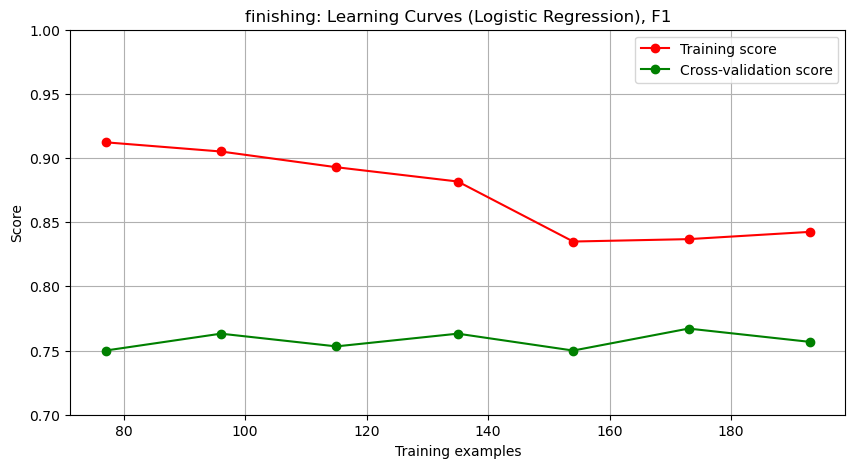

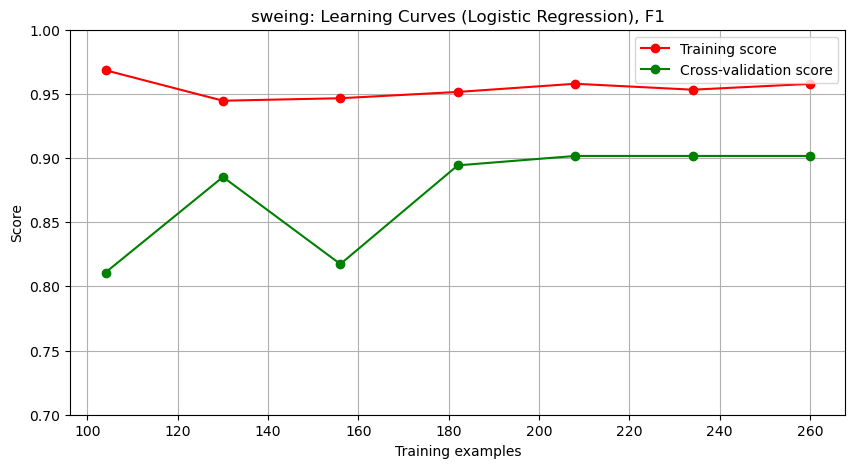

In [43]:
plot_learning_curver(X_train, y_train, tscv_inner=lc_fold, base_pipelines=base_pipelines)

## 'no_of_workers'

accuracy: 0.723 ± 0.027
precision: 0.744 ± 0.051
recall: 0.883 ± 0.020
f1: 0.806 ± 0.030


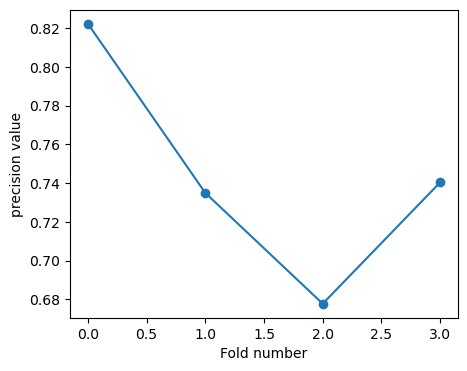

In [44]:
# cross validation

drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'over_time', 'no_of_workers'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'over_time', 'no_of_workers']}
cols_to_scale = {'sweing': ['smv', 'wip', 'incentive'], 
                 'finishing': ['smv']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'],
                                          target_col='bigger_than_targeted', level='team')
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], 
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)

scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

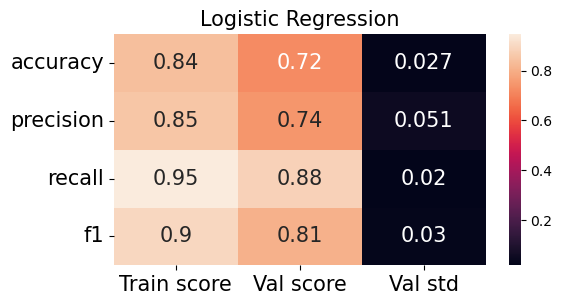

In [45]:
train_val_scores(cv_scores)

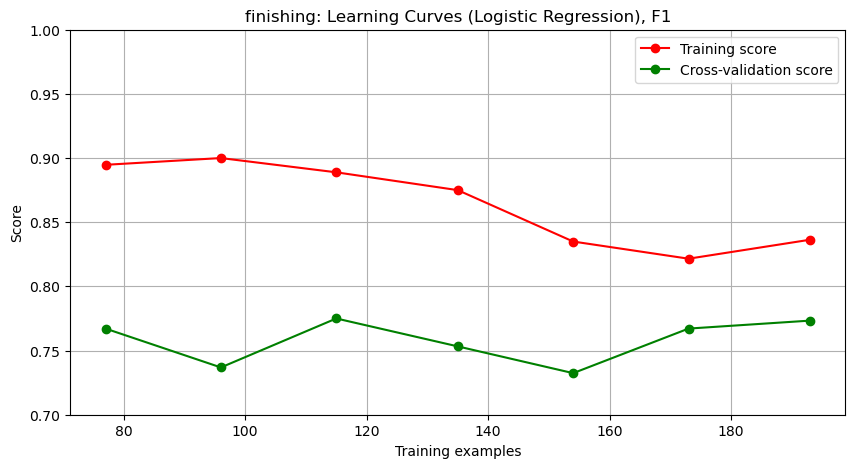

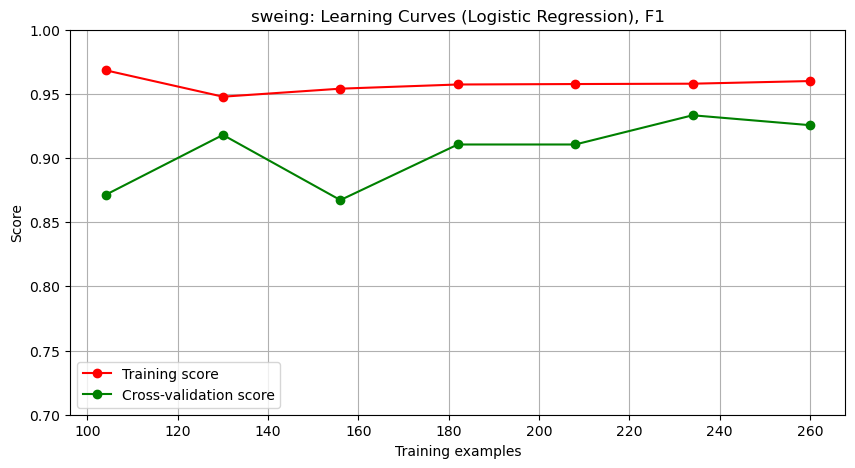

In [46]:
plot_learning_curver(X_train, y_train, tscv_inner=lc_fold, base_pipelines=base_pipelines)

<p><b><u>Conclusion:</u> none of the continuous features contain leaks (level of overfitting stays the same or even increases after dropping such features from the model). That is why the <u>current modelling strategy can be used.</u></b></p>
<p><b><u>Possible solution (to reduce overfitting):</u> add new features, which will help the model to <u>identify differences in target distributions of train and val sets.</u></b></p>

In [47]:
unused_features = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'over_time'],
                   'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'over_time']}

accuracy: 0.730 ± 0.030
precision: 0.750 ± 0.052
recall: 0.882 ± 0.014
f1: 0.810 ± 0.033


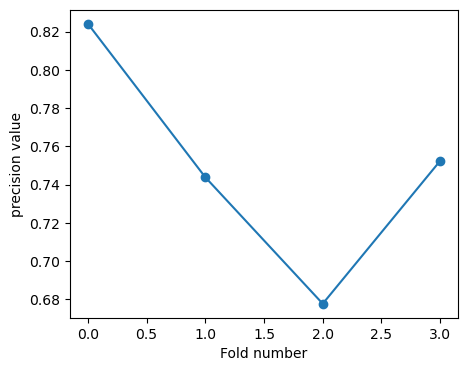

In [48]:
# cross validation

drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'over_time'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'over_time']}
cols_to_scale = {'sweing': ['smv', 'wip', 'incentive', 'no_of_workers'], 
                 'finishing': ['smv', 'no_of_workers']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'],
                                          target_col='bigger_than_targeted', level='team')
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], 
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team')

modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)

scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=True, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

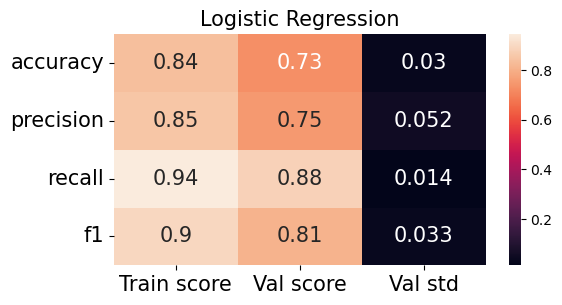

In [49]:
train_val_scores(cv_scores)

# Adversarial validation

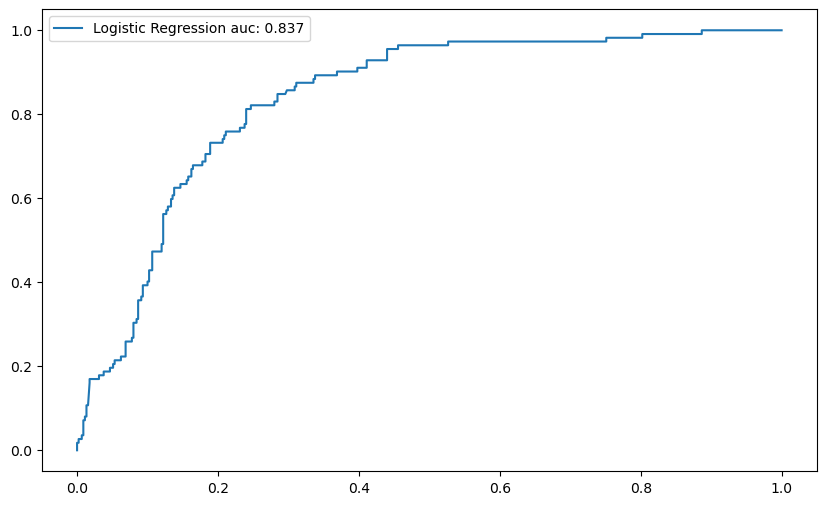

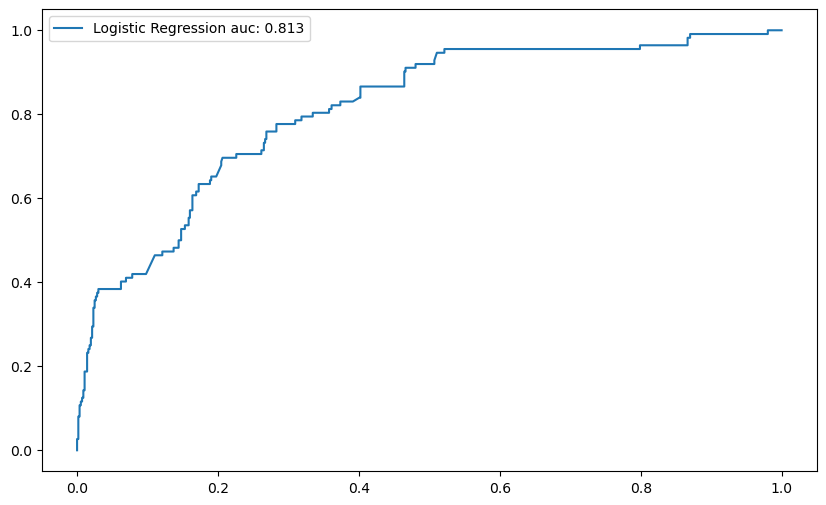

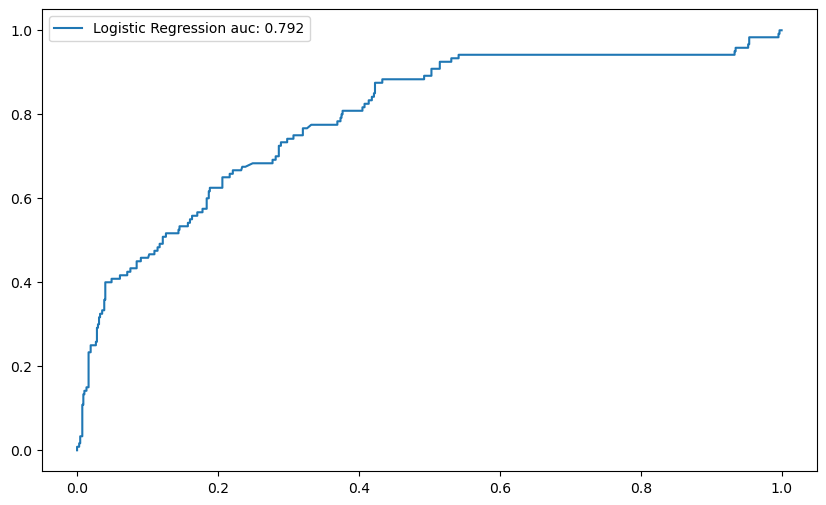

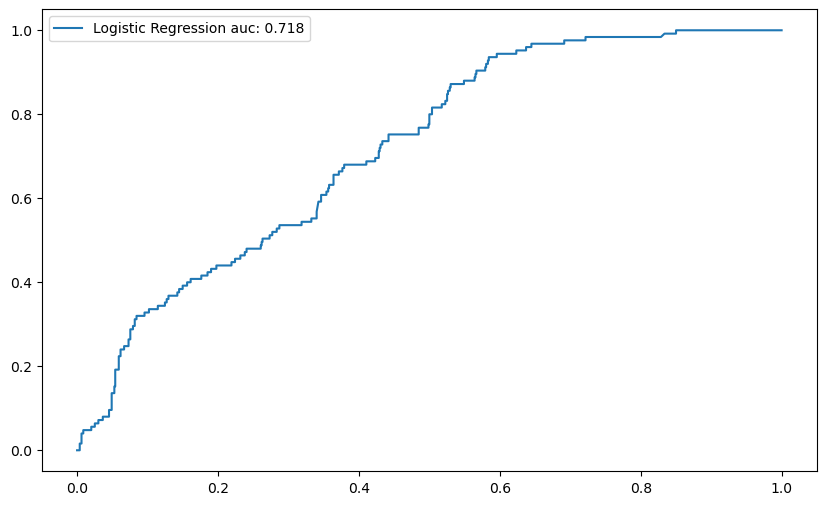

In [50]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler

drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'date', 'department', 'bigger_than_targeted'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'date', 'department', 'bigger_than_targeted']}
cols_to_scale = {'sweing': ['smv', 'wip', 'incentive', 'no_of_workers', 'over_time'], 
                 'finishing': ['smv', 'no_of_workers', 'over_time']}

X_train_copy = X_train.copy()
X_train_copy = pd.get_dummies(X_train_copy, columns=['team'], drop_first=True)

for (train_ind, test_ind) in splitter(X_train_copy):
    X_train_fold, X_test_fold = X_train_copy.loc[train_ind, :], X_train_copy.loc[test_ind, :]
    y_train_fold, y_test_fold = pd.Series(data=0, index=X_train_fold.index), pd.Series(data=1, index=X_test_fold.index)
    X_fold = pd.concat([X_train_fold, X_test_fold])
    y_fold = pd.concat([y_train_fold, y_test_fold])
    
    fold_preds_proba = {}
    for department in X_fold['department'].unique():
        X_fold_dep = X_fold[X_fold['department'] == department].drop(columns=drop_columns[department])
        y_fold_dep = y_fold.loc[X_fold_dep.index]
        
        # scaling
        for col in cols_to_scale[department]:
            scaler = MinMaxScaler()
            X_fold_dep[[col]] = scaler.fit_transform(X_fold_dep[[col]])

        model = LogisticRegression().fit(X_fold_dep, y_fold_dep)
        fold_preds_proba[department] = pd.Series(data=model.predict_proba(X_fold_dep)[:, 1], index=X_fold_dep.index, name='forecast')
    
    y_fold_pred_proba = pd.concat(fold_preds_proba.values()).loc[X_fold.index]
    plt.figure(figsize=(10, 6))
    fpr, tpr, _ = roc_curve(y_fold, y_fold_pred_proba)
    score = roc_auc_score(y_fold, y_fold_pred_proba)
    plt.plot(fpr, tpr, label=f'Logistic Regression auc: {round(score,  3)}')
    plt.legend()

# Lift curves

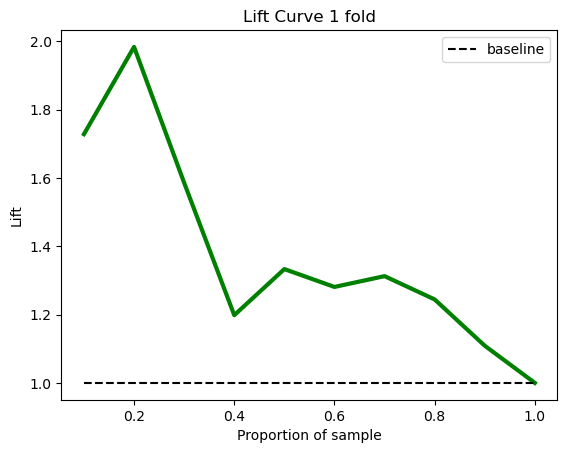

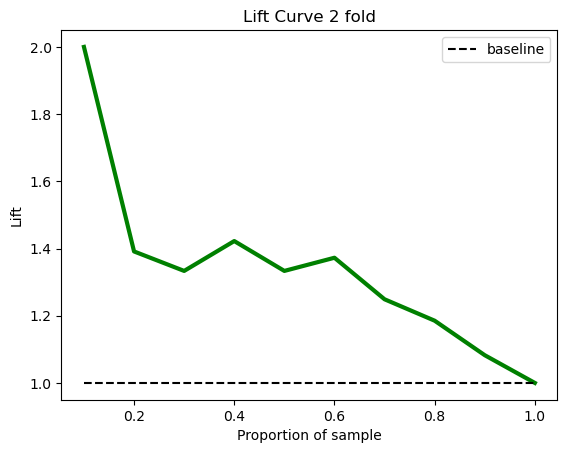

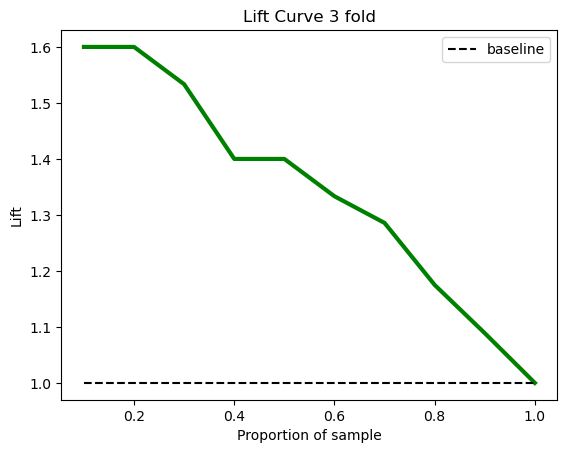

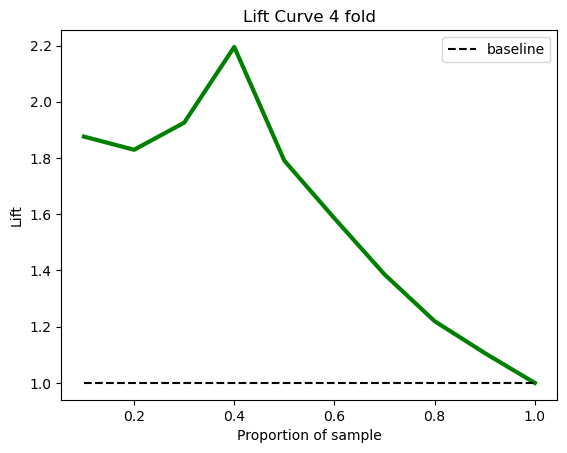

In [51]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler

drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'date', 'department', 'bigger_than_targeted'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive', 'date', 'department', 'bigger_than_targeted']}
cols_to_scale = {'sweing': ['smv', 'wip', 'incentive', 'no_of_workers', 'over_time'], 
                 'finishing': ['smv', 'no_of_workers', 'over_time']}

X_train_copy = X_train.copy()
X_train_copy = pd.get_dummies(X_train_copy, columns=['team'], drop_first=True)

for i, (train_ind, test_ind) in enumerate(splitter(X_train_copy)):
    X_train_fold, X_test_fold = X_train_copy.loc[train_ind, :], X_train_copy.loc[test_ind, :]
    y_train_fold, y_test_fold = y_train.loc[train_ind], y_train.loc[test_ind]
    
    fold_preds_proba = {}
    for department in X_train_fold['department'].unique():
        X_train_fold_dep = X_train_fold[X_train_fold['department'] == department].drop(columns=drop_columns[department])
        y_train_fold_dep = y_train_fold.loc[X_train_fold_dep.index]
        X_test_fold_dep = X_test_fold[X_test_fold['department'] == department].drop(columns=drop_columns[department])
        y_test_fold_dep = y_test_fold.loc[X_test_fold_dep.index]
        
        # scaling
        for col in cols_to_scale[department]:
            scaler = MinMaxScaler()
            X_train_fold_dep[[col]] = scaler.fit_transform(X_train_fold_dep[[col]])
            X_test_fold_dep[[col]] = scaler.transform(X_test_fold_dep[[col]])

        model = LogisticRegression().fit(X_train_fold_dep, y_train_fold_dep)
        fold_preds_proba[department] = pd.Series(data=model.predict_proba(X_test_fold_dep)[:, 1], index=X_test_fold_dep.index, name='forecast')
    
    y_fold_pred_proba = pd.concat(fold_preds_proba.values()).loc[X_test_fold.index]
    plot_lift_curve(y_test_fold, y_fold_pred_proba, title=f'Lift Curve {i + 1} fold')

# Adding new features

### Lags

In [52]:
lags = [1, 2, 3, 4, 5, 6]
X = ETLTransformer(lags=lags).transform(train_data)
y = X['bigger_than_targeted'].copy()

X_train, y_train = X[X['date'] < '2015-03-05'], y.loc[X[X['date'] < '2015-03-05'].index]
X_test, y_test = X[X['date'] >= '2015-03-05'], y.loc[X[X['date'] >= '2015-03-05'].index]

In [53]:
X_sweing, X_finishing = X[X['department'] == 'sweing'], X[X['department'] == 'finishing']
num_sweing = [col for col in X_sweing.columns if col not in ['quarter', 'department', 'day', 'team', 'date']]
num_finishing = [col for col in X_finishing.columns if col not in ['quarter', 'department', 'day', 'team', 'date', 'incentive',
                                                                   'wip', 'idle_time', 'idle_men', 'no_of_style_change']]

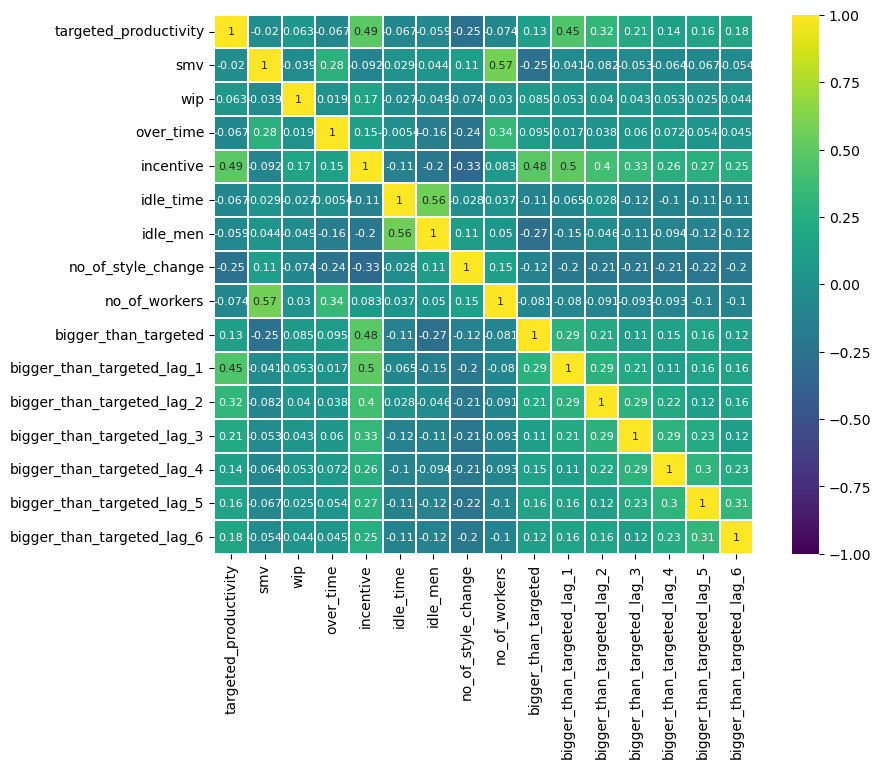

In [54]:
# 'sweing'

corr_sweing = X_sweing.loc[:, num_sweing].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(data=corr_sweing, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.show()

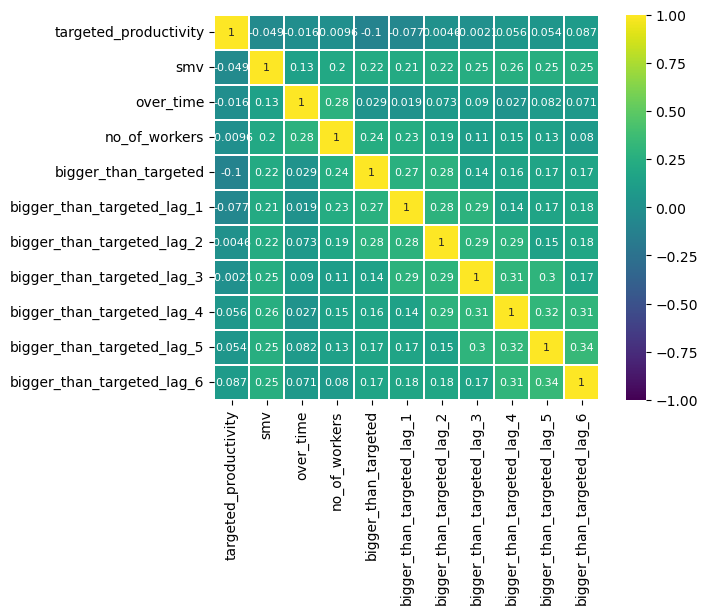

In [55]:
# 'finishing'

corr_finishing = X_finishing.loc[:, num_finishing].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(data=corr_finishing, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.show()

accuracy: 0.695 ± 0.040
precision: 0.716 ± 0.064
recall: 0.895 ± 0.022
f1: 0.793 ± 0.032


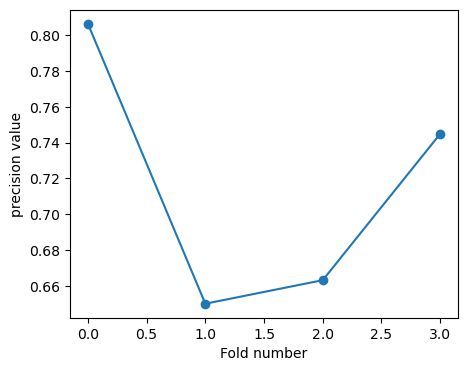

In [56]:
drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men', 'bigger_than_targeted_lag_6'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive']}
cols_to_scale = {'sweing': ['smv', 'incentive', 'over_time'], 
                 'finishing': ['smv', 'no_of_workers', 'over_time']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}
cols_to_standard_scale = {'sweing': ['wip', 'no_of_workers'],
                          'finishing': ['no_of_workers']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'], lags=lags, 
                                          lagged_feature='bigger_than_targeted', target_col='bigger_than_targeted', 
                                          level='team', cols_to_standard_scale=cols_to_standard_scale['sweing'])
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], cols_to_standard_scale=cols_to_standard_scale['finishing'],
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team',
                                             lags=lags, lagged_feature='bigger_than_targeted')
modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)
scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=False, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

In [57]:
date_range_final = X_train['date'].unique()[test_size:]
X_train_final, y_train_final = X_train[X_train['date'].isin(date_range_final)], y_train.loc[X_train[X_train['date'].isin(date_range_final)].index]

modelling_pipeline_logreg.fit(X_train_final, y_train_final)
final_preds = modelling_pipeline_logreg.predict(X_test)
final_preds_metrics(y_test, final_preds)

accuracy: 0.783
precision: 0.849
recall: 0.882
f1: 0.865


### Rolling features

In [58]:
lags = [1]
rolling_days = [1, 2, 3]
rolling_aggr = {np.mean: 'mean'}

X = ETLTransformer(lags=lags, rolling_days=rolling_days, rolling_aggr=rolling_aggr).transform(train_data)
y = X['bigger_than_targeted'].copy()

X_train, y_train = X[X['date'] < '2015-03-05'], y.loc[X[X['date'] < '2015-03-05'].index]
X_test, y_test = X[X['date'] >= '2015-03-05'], y.loc[X[X['date'] >= '2015-03-05'].index]

In [59]:
X_sweing, X_finishing = X[X['department'] == 'sweing'], X[X['department'] == 'finishing']
num_sweing = [col for col in X_sweing.columns if col not in ['quarter', 'department', 'day', 'team', 'date']]
num_finishing = [col for col in X_finishing.columns if col not in ['quarter', 'department', 'day', 'team', 'date', 'incentive',
                                                                   'wip', 'idle_time', 'idle_men', 'no_of_style_change']]

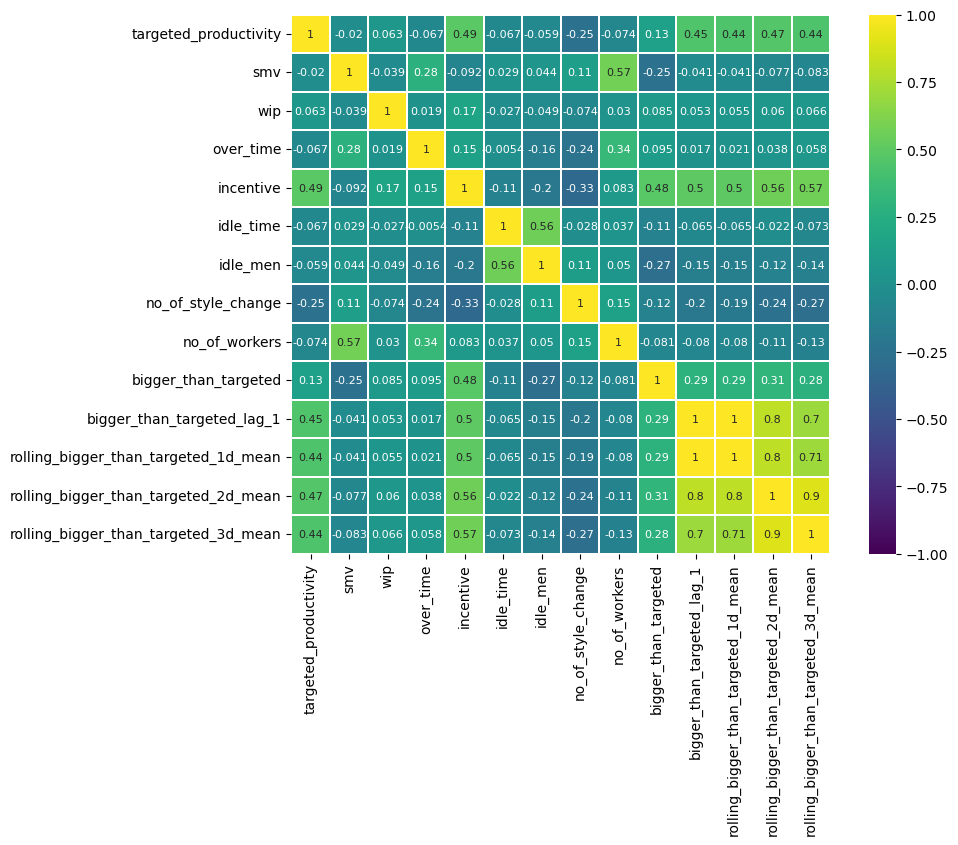

In [60]:
# 'sweing'

corr_sweing = X_sweing.loc[:, num_sweing].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(data=corr_sweing, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.show()

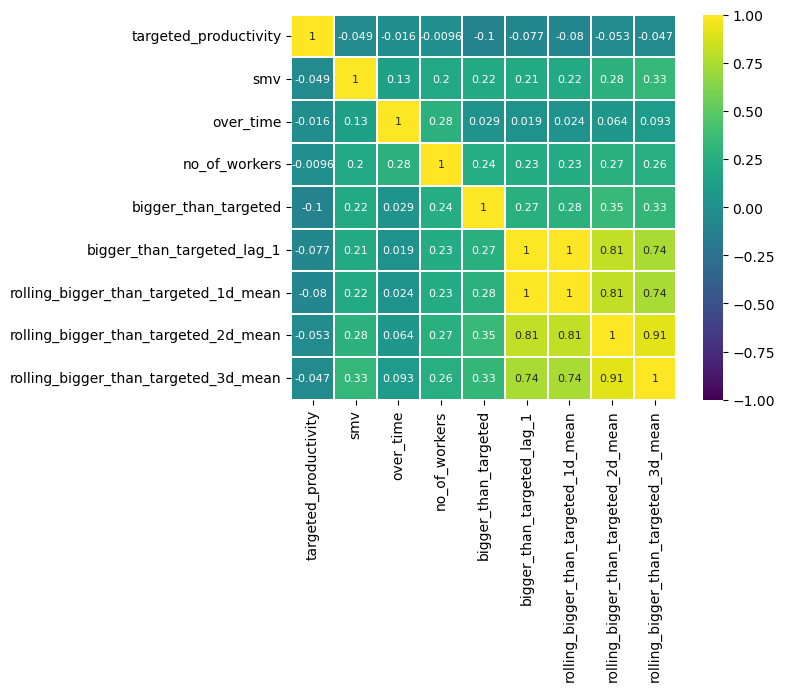

In [61]:
# 'finishing'

corr_finishing = X_finishing.loc[:, num_finishing].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(data=corr_finishing, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.show()

accuracy: 0.699 ± 0.045
precision: 0.725 ± 0.076
recall: 0.890 ± 0.038
f1: 0.795 ± 0.031


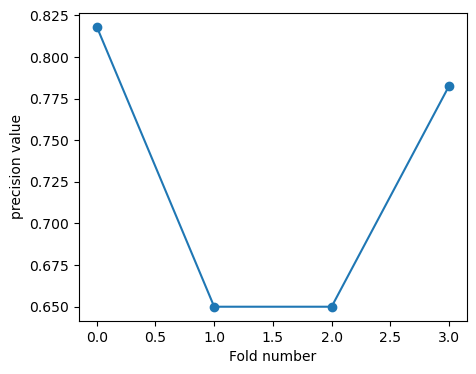

In [62]:
drop_columns = {'sweing': ['day', 'quarter', 'idle_time', 'no_of_style_change', 'idle_men'],
                'finishing': ['day', 'quarter', 'wip', 'idle_time', 'idle_men', 'no_of_style_change', 'incentive']}
cols_to_scale = {'sweing': ['smv', 'incentive', 'over_time'], 
                 'finishing': ['smv', 'no_of_workers', 'over_time']}
cols_to_encode = {'sweing': ['team'],
                  'finishing': ['team']}
cols_to_standard_scale = {'sweing': ['wip', 'no_of_workers'],
                          'finishing': ['no_of_workers']}

base_pipelines = {}
base_pipelines['sweing'] = LogRegPipeline(cols_to_scale=cols_to_scale['sweing'], cols_to_encode=cols_to_encode['sweing'], 
                                          split_key='department', drop_columns=drop_columns['sweing'], lags=lags,
                                          lagged_feature='bigger_than_targeted', target_col='bigger_than_targeted', 
                                          level='team', cols_to_standard_scale=cols_to_standard_scale['sweing'],
                                          rolling_col='bigger_than_targeted', rolling_days=rolling_days, rolling_aggr=rolling_aggr)
base_pipelines['finishing'] = LogRegPipeline(cols_to_scale=cols_to_scale['finishing'], cols_to_standard_scale=cols_to_standard_scale['finishing'],
                                             cols_to_encode=cols_to_encode['finishing'], drop_columns=drop_columns['finishing'],
                                             split_key='department', target_col='bigger_than_targeted', level='team',
                                             lags=lags, lagged_feature='bigger_than_targeted',
                                             rolling_col='bigger_than_targeted', rolling_days=rolling_days, rolling_aggr=rolling_aggr)
modelling_pipeline_logreg = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='department',
                                                 target_col='bigger_than_targeted', learning_curve=True)
scores = cross_validate(modelling_pipeline_logreg, X_train, y_train, cv=splitter(X_train), scoring=CV_METRICS, 
                        return_estimator=True, error_score='raise', return_train_score=False, n_jobs=-1)
cv_scores = format_cv_test_scores(scores, metrics_to_plot=['precision'], save_scores=True, save_train_scores=True)

In [63]:
date_range_final = X_train['date'].unique()[test_size:]
X_train_final, y_train_final = X_train[X_train['date'].isin(date_range_final)], y_train.loc[X_train[X_train['date'].isin(date_range_final)].index]

modelling_pipeline_logreg.fit(X_train_final, y_train_final)
final_preds = modelling_pipeline_logreg.predict(X_test)
final_preds_metrics(y_test, final_preds)

accuracy: 0.806
precision: 0.853
recall: 0.912
f1: 0.882
